In [6]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/rdgao/Documents/code/research/spectralCV')
sys.path.append('/Users/rdgao/Documents/code/research/neurodsp/')
sys.path.append('/Users/rdgao/Documents/code/research/fooof/')
sys.path.append('/Users/rdgao/Documents/code/research/SpaceRecon/')

import neurodsp.spectral as spectral
from nlds import delayembed as de
from nlds import dfa, utils

%matplotlib inline

# imports
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os

font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 13}
import matplotlib
matplotlib.rc('font', **font)

import neurodsp as ndsp
from fooof import FOOOFGroup
from scv_funcs import lfpca
from scv_funcs import utils
from scv_funcs import access_nt as asc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# load psd, fooof & dfa results
def load_results(basefolder, filename, load_psd=True, load_fooof=True, load_dfa=True):
    psd_data, fooof_data, dfa_data = [], [], []
    if load_psd:
        psd_data = np.load(basefolder+'psd/'+filename)
        print(list(psd_data.keys()))
    if load_fooof:
        fooof_data = np.load(basefolder+'psd/fooof/'+filename)
        print(list(fooof_data.keys()))
    if load_dfa:    
        dfa_data = np.load(basefolder+'dfa/'+filename)
        print(list(dfa_data.keys()))
    
    return psd_data, fooof_data, dfa_data


def load_fooof_results(basefolder, filename):
    fooof_data = np.load(basefolder+filename)
    print(list(fooof_data.keys()))
    return fooof_data

In [102]:
def nt_dfa(data, fs):
    numchan=data.shape[0]
    dfa_ = np.zeros(numchan)
    for chan in range(numchan):
        # compute DFA
        t_scales, df, alpha = dfa.dfa(data[chan,:],fs,n_scales=20, deg=1, method='dfa')
        dfa_[chan]=alpha

    return dfa_

def nt_nonlinear(data, fs):
    numchan=data.shape[0]
    nt_metrics = np.zeros((numchan, 3))
    for chan in range(numchan):
        print('dfa')
        # compute DFA
        t_scales, df, alpha = dfa.dfa(data[chan,:],fs,n_scales=20, deg=1, method='dfa')
        print('MI')
        # compute MI 
        tMI, dMI = de.compute_delay_MI(data[chan,:],50,int(fs))
        opt_delay = de.find_valley(dMI)
        # compute delay-embedding pfnn
        print('pfnn')
        recon_dim, pfnn = de.pfnn_de_dim(data[chan,:],tau=opt_delay[0],max_dim=7)
        nt_metrics[chan,:] = np.array([alpha,opt_delay,recon_dim])

    return nt_metrics

def tau_from_C(knee):
    return np.sqrt(1/knee)/(2*np.pi)

### load FOOOF results

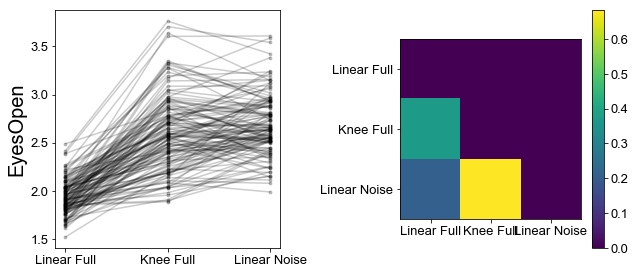

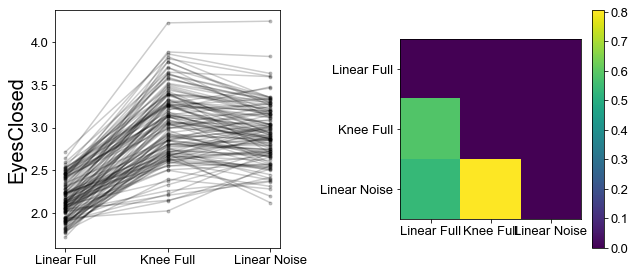

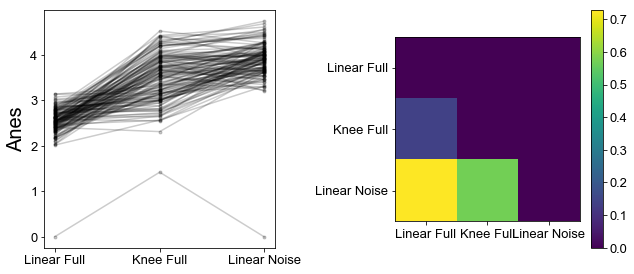

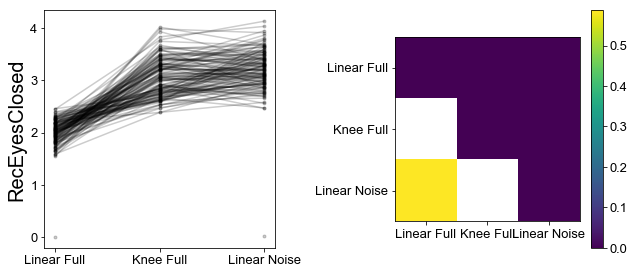

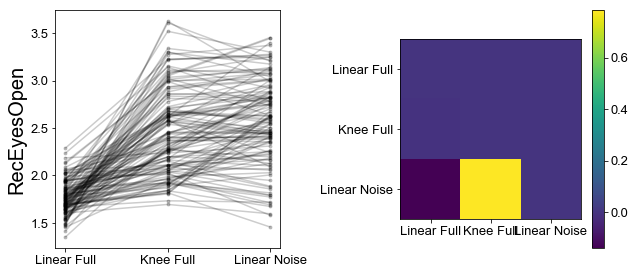

In [103]:
#fooof_conds = [('fixed',[3,100]),('knee',[3,100]),('fixed',[40,70])]
session_labels = ['EyesOpen', 'EyesClosed', 'Anes', 'RecEyesClosed', 'RecEyesOpen']
saveout_path = "/Users/rdgao/Documents/code/research/spectralCV/results/nt/"
fooof_files = sorted([f for f in os.listdir(saveout_path) if 'fooof' in f])
fooof_data_all=[]
for ind, f in enumerate(fooof_files):    
    fooof_data = np.load(saveout_path+f)
    fooof_data_all.append(fooof_data['fooof_res'])
    #slope knee r2
    plt.figure(figsize=(9,4))
    plt.subplot(1,2,1)
    plt.plot(fooof_data['fooof_res'][:,0,:].T,'.-k', alpha=0.2)
    plt.ylabel(session_labels[ind], fontsize=20)
    plt.xticks(range(3), ('Linear Full', 'Knee Full', 'Linear Noise'))
    plt.subplot(1,2,2)    
    plt.imshow(np.tril(np.corrcoef(fooof_data['fooof_res'][:,0,:].T),k=-1))
    plt.colorbar()
    plt.xticks(range(3), ('Linear Full', 'Knee Full', 'Linear Noise'))    
    plt.yticks(range(3), ('Linear Full', 'Knee Full', 'Linear Noise'))
    plt.tight_layout()

### Compute nonlinear features

In [5]:
data_path ="/Users/rdgao/Documents/data/NeuroTycho/Propofol/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/Session%d/"
fs = 1000
session_indices = [(1,0,1), (1,2,3), (2,1,2), (2,3,4), (3,0,1)]
session_labels = ['EyesOpen', 'EyesClosed', 'Anes', 'RecEyesClosed', 'RecEyesOpen']
fooof_conds = [('fixed',[3,100]),('knee',[3,100]),('fixed',[40,70])]

chan = range(1,129)
dfa_ = np.zeros((len(chan),len(session_indices)))

for i in range(0,len(session_indices)):
    print(i)
    session_ind = session_indices[i]
    session = session_ind[0]
    start_ind = session_ind[1]
    end_ind = session_ind[2]
    
    # with specified indices
    indices = asc.get_cond(data_path, session, start_ind, end_ind)
    data = asc.get_ECoG(data_path, session, chan, indices)    
    
    # compute metrics
    dfa_[:,i] = nt_dfa(data,fs)     

np.savez(saveout_path+'dfa.npz', NT_dfa=dfa_)

0
AwakeEyesOpened-Start AwakeEyesOpened-End


KeyboardInterrupt: 

### Slope - DFA relationship

In [71]:
dfa_ = np.load(saveout_path+'dfa.npz')['NT_dfa']

/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3239: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))
/Users/rdgao/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/rdgao/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/rdgao/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/rdgao/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/rdgao/anaconda3/lib/python3.6/site-packages/s

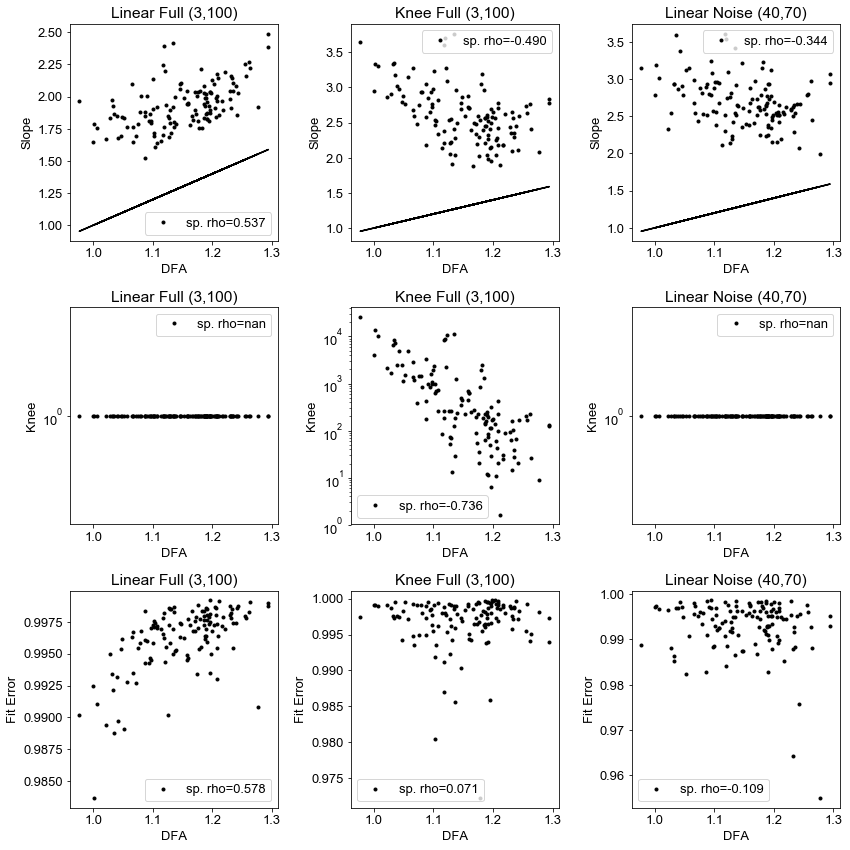

In [72]:
plt_inds = np.where(fooof_data_all[2][:,0,0]>1)[0]
cond = 0
fooof_conds = ('Linear Full (3,100)', 'Knee Full (3,100)', 'Linear Noise (40,70)')
fooof_feats = ('Slope', 'Knee', 'Fit Error')
plt.figure(figsize=(12,12))
for j, ff in enumerate(fooof_feats):
    for i, fc in enumerate(fooof_conds):
        plt.subplot(3,3,j*3+i+1)
        plt.plot(dfa_[plt_inds,cond], fooof_data_all[cond][plt_inds,j,i], '.k')
        if j==0: plt.plot(dfa_[plt_inds,cond], dfa_[plt_inds,cond]*2-1, 'k-')
        if j==1: plt.yscale('log')
        plt.xlabel('DFA')
        plt.ylabel(ff)
        plt.title(fc)
        #rho, pv = sp.stats.pearsonr(dfa_[plt_inds,cond], fooof_data_all[cond][plt_inds,j,i])
        rho, pv = sp.stats.spearmanr(dfa_[plt_inds,cond], fooof_data_all[cond][plt_inds,j,i])
        plt.legend(['sp. rho=%.3f'%rho])
    plt.tight_layout()

In [3]:
chibi_ctx_file = '/Users/rdgao/Documents/data/NeuroTycho/Propofol/GridLocations/20110621KTMD_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_2Dimg/ChibiMap.mat'
chibi_map = '/Users/rdgao/Documents/data/NeuroTycho/Propofol/GridLocations/brainmap-Chibi-v2.jpg'
ctx_mat = sp.io.loadmat(chibi_ctx_file, squeeze_me=True)

george_ctx_file = '/Users/rdgao/Documents/data/NeuroTycho/Propofol/GridLocations/20110621KTMD_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_2Dimg/ChibiMap.mat'
george_map = '/Users/rdgao/Documents/data/NeuroTycho/Propofol/GridLocations/brainmap-Chibi-v2.jpg'
ctx_mat = sp.io.loadmat(george_ctx_file, squeeze_me=True)


cond = 0
tau_knee = tau_from_C(fooof_data_all[cond][:,1,1])*1000

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(tau_knee, dfa_[:,cond], '.k')
plt.xlabel('Time Constant (ms)')
plt.ylabel('DFA alpha')
plt.xlim([0,75])
plt.subplot(1,2,2)
asc.ctx_viz(ctx_file, data=tau_knee,  ms=40.)
plt.title('Inferred Time Constant')
plt.tight_layout()

NameError: name 'tau_from_C' is not defined

![](../../img/chibi_murray.png)

In [4]:
# loading all fooof results
fooof_path = '/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/'
fooof_files = sorted([ff for ff in os.listdir(fooof_path) if '.npz' in ff])
conds = ['EyesOpen', 'EyesClosed', 'Delivery', 'Anesthesia']
cond = conds[0]
fit_type = 'bg_kn_med' #bg_kn, bg_kn_med
fit_feat = 'slope'

fits, subj = [],[]
for ff in fooof_files:
    metadata = [ff.split('_')[i] for i in [1,2,3,7]]
    if cond in metadata:
        fooof_data=np.load(fooof_path+ff)
        fits.append(fooof_data[fit_type])
        subj.append(metadata[-1])
            
fits = np.dstack(fits)

# collect data from electrodes
cell_ts = {'MT':[77.,64.], 'LIP':[138., 91.], 'LPFC':[184.,180.,195.,162.], 'OFC':[176.,188.], 'ACC':[313.,340.,257.], 'S1':[65.], 'S2':[149.]}
cell_ts_avg = {}

# consult map for these coords
loc_inds_chibi = {'MT':[3,4,109], 'LIP':[10,11], 'LPFC':[14,15,25,26], 'OFC':[23,34,45], 'ACC':[52,57,58,59], 'S1':[9,19], 'S2':[95,108]}
loc_inds_george = {'MT':[4,13,22], 'LIP':[10,11,20,21], 'LPFC':[15,24,25,26], 'OFC':[45,66], 'ACC':[52,57,58,59], 'S1':[18,19,30], 'S2':[1,2,9,108]}
loc_inds = {'Chibi': loc_inds_chibi, 'George': loc_inds_george}

ecog_ts = {}
ecog_ts_avg = {}
for i,key in enumerate(cell_ts.keys()):
    ecog_ts[key]=[]
    for rec in range(fits.shape[2]):
        cur_locs = np.array(loc_inds[subj[rec]][key])-1
        if fit_feat is 'knee':
            ecog_ts[key].append(tau_from_C(fits[cur_locs,1,rec])*1000)
        elif fit_feat is 'slope':
            ecog_ts[key].append(fits[cur_locs,-1,rec])

    ecog_ts_avg[key] = np.array([[np.nanmean(ts), np.nanstd(ts)] for ts in ecog_ts[key]])
    cell_ts_avg[key] = np.array([np.mean(cell_ts[key]), np.std(cell_ts[key])])

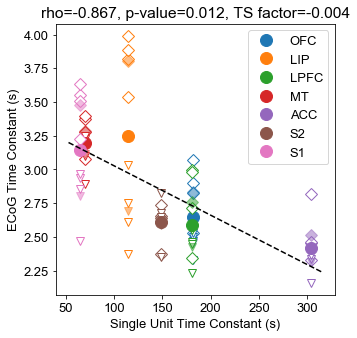

In [5]:
_, subj_ind = np.unique(subj, return_inverse=True) # get subject indices
CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']
labels=['D','v']
loc_ord = ['OFC', 'LIP', 'LPFC', 'MT', 'ACC', 'S2', 'S1']
plot_ord = [4,2,3,1,5,7,6]

# plotting
plt.figure(figsize=(5,5))
for i,key in enumerate(loc_ord):
    for s in np.unique(subj_ind):
        plt.plot(cell_ts_avg[key][0]*np.ones(sum(subj_ind==s)), ecog_ts_avg[key][subj_ind==s,0], labels[s], alpha=1, ms=8, mfc='w',color=CKEYS[i])
        plt.plot(cell_ts_avg[key][0], ecog_ts_avg[key][subj_ind==s,0].mean(), labels[s], alpha=0.5, ms=8, color=CKEYS[i])
    plt.plot(cell_ts_avg[key][0], ecog_ts_avg[key][:,0].mean(), 'o', ms=12, label=key, color=CKEYS[i])

plt.legend()
plt.xlabel('Single Unit Time Constant (s)')
plt.ylabel('ECoG Time Constant (s)')

# stats on grand average
ts_means = np.array([[cell_ts_avg[key][0], ecog_ts_avg[key][:,0].mean()] for key in loc_ord])
W = np.polyfit(ts_means[:,0],ts_means[:,1],1)
XL = np.array(plt.xlim())
plt.plot(XL, XL*W[0]+W[1], 'k--')
rho,pv = sp.stats.pearsonr(ts_means[:,0], ts_means[:,1])
plt.title('rho=%.3f, p-value=%.3f, TS factor=%0.3f'%(rho,pv,W[0]));


In [ ]:
# old code

In [246]:
# loading fooof results
basefolder = '/Users/rdgao/Documents/data/NeuroTycho/results/'
monkey = 'chibi'

if monkey is 'chibi':
    chibi_ctx_file = '/Users/rdgao/Documents/data/NeuroTycho/Propofol/GridLocations/20110621KTMD_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_2Dimg/ChibiMap.mat'
    chibi_map = '/Users/rdgao/Documents/data/NeuroTycho/Propofol/GridLocations/brainmap-Chibi-v2.jpg'
    ctx_mat = sp.io.loadmat(chibi_ctx_file, squeeze_me=True)
    loc_inds = {'MT':[3,4,109], 'LIP':[10,11], 'LPFC':[14,15,25,26], 'OFC':[23,34,45], 'ACC':[52,57,58,59], 'S1':[9,19], 'S2':[95,108]}
    sessionfile = 'Propofol_20120730PF_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz'
    
elif monkey is 'george':
    george_ctx_file = '/Users/rdgao/Documents/data/NeuroTycho/Propofol/GridLocations/20110112KTMD_Anesthesia+and+Sleep_George_Toru+Yanagawa_mat_2Dimg/GeorgeMap.mat'
    george_map = '/Users/rdgao/Documents/data/NeuroTycho/Propofol/GridLocations/Brainmap-George-v2.jpg'
    ctx_mat = sp.io.loadmat(george_ctx_file, squeeze_me=True)
    loc_inds = {'MT':[4,13,22], 'LIP':[10,11,20,21], 'LPFC':[15,24,25,26], 'OFC':[45,66], 'ACC':[52,57,58,59], 'S1':[18,19,30], 'S2':[1,2,9,108]}
    sessionfile = 'Propofol_20120731PF_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz'

conds = ['0_EyesOpen_', '1_EyesClosed_', '2_Delivery_', '3_Anesthesia_']

cond = conds[0]
fooof_data = load_fooof_results(basefolder+'psd/1sec_win/fooof/', cond+sessionfile)

['bg', 'pks', 'ftns', 'bg_kn', 'pks_kn', 'ftns_kn', 'bg_med', 'pks_med', 'ftns_med', 'bg_kn_med', 'pks_kn_med', 'ftns_kn_med', 'fooof_range']


/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in sqrt
/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


OFC [ 1.81126372  2.49235728 16.15769426]
LIP [0.45311705 0.42965122]
LPFC [2.43222573 2.97160674 3.61778378 1.61026514]
MT [1.19137393 1.17726005 4.03987763]
ACC [20.08921153 20.24620842 14.42588947 16.65301828]
S2 [6.71273593 2.60036422]
S1 [1.17020707 0.56803355]
Timescale factor = 0.067


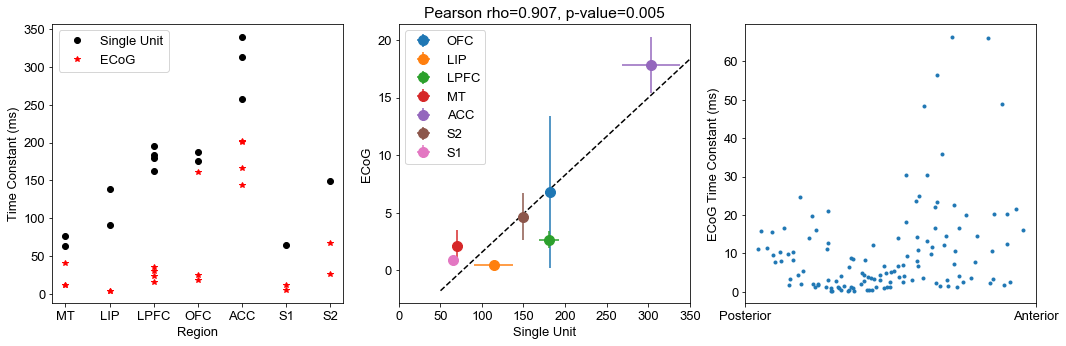

In [248]:
cell_ts = {'MT':[77.,64.], 'LIP':[138., 91.], 'LPFC':[184.,180.,195.,162.], 'OFC':[176.,188.], 'ACC':[313.,340.,257.], 'S1':[65.], 'S2':[149.]}
loc_ord = ['OFC', 'LIP', 'LPFC', 'MT', 'ACC', 'S2', 'S1']
plot_ord = [4,2,3,1,5,7,6]

# cond = 1
# tau_knee = tau_from_C(fooof_data_all[cond][:,1,1])*1000

tau_knee = tau_from_C(fooof_data['bg_kn'][:,1])*1000

# slope_knee = fooof_data_all[cond][:,2,1]
# slope_lin = fooof_data_all[cond][:,2,0]
# slope_noise = fooof_data_all[cond][:,2,2]
#tau_knee = slope_knee
ts_factor = 10
ts_mean = []
plt.figure(figsize=(15,5))
for i,key in enumerate(loc_ord):
    plt.subplot(1,3,1)
    t_cell = np.asarray(cell_ts[key])
    plt.plot(plot_ord[i]*np.ones_like(t_cell), t_cell, 'ko')
    t_region = tau_knee[np.array(loc_inds[key])-1]
    plt.plot(plot_ord[i]*np.ones_like(t_region), t_region*ts_factor, 'r*')
    plt.subplot(1,3,2)
    plt.errorbar(t_cell.mean(), t_region.mean(), yerr=t_region.std(), xerr=t_cell.std(), fmt='o', ms=10, label=key)
    ts_mean.append([t_cell.mean(), t_region.mean()])
    print(key,t_region)

ts_mean = np.asarray(ts_mean)

plt.subplot(1,3,1)
plt.xticks(plot_ord,loc_ord)
plt.xlabel('Region')
plt.ylabel('Time Constant (ms)')
plt.legend(['Single Unit', 'ECoG'])

plt.subplot(1,3,2)
W = np.polyfit(ts_mean[:,0], ts_mean[:,1], deg=1)
XL = np.array(plt.xlim())
plt.plot(XL, XL*W[0]+W[1], 'k--')
print('Timescale factor = %.3f'%W[0])
plt.title('Pearson rho=%.3f, p-value=%.3f'%sp.stats.pearsonr(ts_mean[:,0], ts_mean[:,1]))

plt.legend()
plt.xlim([0,350])
plt.xlabel('Single Unit')
plt.ylabel('ECoG')

plt.subplot(1,3,3)
plt.plot(-ctx_mat['X'], tau_knee, '.')

plt.xticks(plt.xlim(), ['Posterior', 'Anterior'])
plt.ylabel('ECoG Time Constant (ms)')
plt.tight_layout()


# Macaque ECoG vs. Spiking Timescale
As shown in the second panel, single unit spiking timescale correlates with ECoG characteristic timescale across cortical areas. More generally, timescale increases moving from posterior to anterior regions of the brain, "up the cortical hierarchy".

However, there is a conversion factor of ~0.1 from LFP to spiking, i.e. LFP timescale is 1/10 of single unit spike timing timescale. Why is that?
1. timescale correlation is due to chance, or some other factor in the ECoG, e.g., dendritic/membrane integration constant
2. spiking is local output, whereas ECoG is (mostly) input, so the time constant measured in ECoG is spiking from the afferent region
3. single unit time constant is different from population time constant, which has been proposed as the benefit of asynchronous population spiking (faster reaction, e.g., van Vreeswijk, Destexhe)
4. local recurrent dendritic processes "filter" spiking, most likely in a low-pass fashion. Thus, whatever process with the highest time constant (lower frequency knee) will dominate in the retrieved timescale
5. they have nothing to do with each other and this is just random

**Should try gamma or broadband power autocorrelation over time to match with the spiking timescale.**